<a href="https://colab.research.google.com/github/analyticswithharry/RegressionAnalysisUsingPython/blob/main/GradientBoostingQuantileRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosting Quantile Regression

**HEMANT THAPA**

The GradientBoostingQuantileRegression class is designed to model the relationship between the closing prices of Tesla stock and the S&P 500 index using quantile regression with Gradient Boosting. This approach is especially useful when you want to generate predictions that reflect the uncertainty inherent in stock prices, providing not just a single predicted value but a range of possible outcomes. Quantile regression allows the model to estimate various quantiles (e.g., 5th, 50th, and 95th percentiles), rather than just the mean, which helps in creating prediction intervals that can be used for risk assessment or scenario analysis.

The class uses Gradient Boosting Regressors to fit models that predict multiple quantiles (e.g., 5th, 50th, and 95th percentiles) of Tesla’s stock price. This is useful for generating predictions that account for different levels of uncertainty. The model also includes a baseline Mean Squared Error (MSE) model for comparison.

Once the model is trained, you can use it to make predictions across a range of S&P 500 closing prices. The predicted values include not only the mean but also the lower and upper bounds of a prediction interval (e.g., a 90% interval). This allows you to visualize the potential range of Tesla’s stock price based on different market conditions, which is crucial for understanding the risk and volatility in the market.

The class provides functions to evaluate the model's performance using Pinball Loss and Mean Squared Error. Pinball loss is particularly suited for quantile regression, as it accounts for the asymmetric nature of errors in different quantiles. This evaluation can be done both on the training data (to assess how well the model has learned the relationship) and on the test data (to assess generalization and out-of-sample performance).

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
import pandas as pd

In [37]:
class GradientBoostingQuantileRegression:
    def __init__(self, ticker_symbol='TSLA', index_symbol='^GSPC', start_date='2020-01-01', end_date='2024-11-09',
                 x_label='$x$ (S&P 500 Closing Price)', y_label='$y$ (Tesla Closing Price)', title=None):
        self.ticker_symbol = ticker_symbol
        self.index_symbol = index_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.x_label = x_label
        self.y_label = y_label
        self.title = title or f"Gradient Boosting Quantile Regression: {self.index_symbol} vs {self.ticker_symbol}"
        self.models = {}
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.xx = None
        self.download_data()
        self.split_data()

    def download_data(self):
        self.tesla = yf.download(self.ticker_symbol, start=self.start_date, end=self.end_date)
        self.sp500 = yf.download(self.index_symbol, start=self.start_date, end=self.end_date)

    def split_data(self):
        X = self.sp500['Close'].values.reshape(-1, 1)
        y = self.tesla['Close'].values.ravel()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=0)

    def train_models(self):
        common_params = dict(
            learning_rate=0.05,
            n_estimators=200,
            max_depth=2,
            min_samples_leaf=9,
            min_samples_split=9,
        )
        for alpha in [0.05, 0.5, 0.95]:
            gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
            self.models[f"q {alpha:.2f}"] = gbr.fit(self.X_train, self.y_train)

        gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
        self.models["mse"] = gbr_ls.fit(self.X_train, self.y_train)

    def make_predictions(self):
        self.xx = np.atleast_2d(np.linspace(self.X_train.min(), self.X_train.max(), 1000)).T
        self.y_pred = self.models["mse"].predict(self.xx)
        self.y_lower = self.models["q 0.05"].predict(self.xx)
        self.y_upper = self.models["q 0.95"].predict(self.xx)
        self.y_med = self.models["q 0.50"].predict(self.xx)

    def plot_prediction(self):
        fig = plt.figure(figsize=(10, 6))
        plt.plot(self.X_test, self.y_test, "b.", markersize=10, label="Test observations")
        plt.plot(self.xx, self.y_med, "r-", label="Predicted median (quantile=0.50)")
        plt.plot(self.xx, self.y_pred, "r-", label="Predicted mean (MSE)")
        plt.plot(self.xx, self.y_upper, "k-", label="Predicted 95th percentile")
        plt.plot(self.xx, self.y_lower, "k-", label="Predicted 5th percentile")
        plt.fill_between(self.xx.ravel(), self.y_lower, self.y_upper, alpha=0.4, label="Predicted 90% interval")
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        plt.grid(True, ls='--', alpha=0.3, color='black')
        plt.ylim(-10, 1000)
        plt.legend(loc="upper left")
        plt.title(self.title)
        plt.show()

    def highlight_min(self, x):
        x_min = x.min()
        return ["font-weight: bold" if v == x_min else "" for v in x]

    def evaluate_models(self):
        results = []
        for name, gbr in sorted(self.models.items()):
            metrics = {"model": name}
            y_pred = gbr.predict(self.X_train)
            for alpha in [0.05, 0.5, 0.95]:
                metrics[f"pbl={alpha:.2f}"] = mean_pinball_loss(self.y_train, y_pred, alpha=alpha)
            metrics["MSE"] = mean_squared_error(self.y_train, y_pred)
            results.append(metrics)
        return pd.DataFrame(results).set_index("model").style.apply(self.highlight_min)

    def evaluate_test_models(self):
        results_test = []
        for name, gbr in sorted(self.models.items()):
            metrics = {"model": name}
            y_pred = gbr.predict(self.X_test)
            for alpha in [0.05, 0.5, 0.95]:
                metrics[f"pbl={alpha:.2f}"] = mean_pinball_loss(self.y_test, y_pred, alpha=alpha)
            metrics["MSE"] = mean_squared_error(self.y_test, y_pred)
            results_test.append(metrics)
        return pd.DataFrame(results_test).set_index("model").style.apply(self.highlight_min)


In [38]:
ticker = 'TSLA'
index = '^GSPC'
start_date = '2020-01-01'
end_date = '2024-11-09'
x_label = 'S&P 500 Closing Price'
y_label = 'Tesla Closing Price'
title = 'Gradient Boosting Regression: S&P 500 vs Tesla'

model = GradientBoostingQuantileRegression(
    ticker_symbol=ticker, index_symbol=index, start_date=start_date, end_date=end_date,
    x_label=x_label, y_label=y_label, title=title
)
model

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


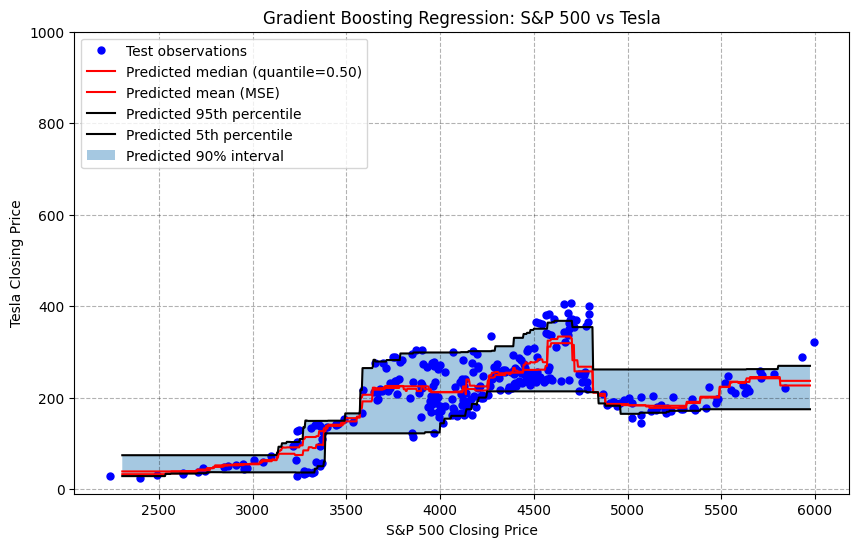

In [39]:
model.train_models()
model.make_predictions()
model.plot_prediction()

In [40]:
train_results = model.evaluate_models()
print("Training Set Evaluation Results:")
display(train_results)

Training Set Evaluation Results:


,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,12.823690,12.823690,12.823690,1168.738957
q 0.05,2.988685,27.941881,52.895078,5277.752747
q 0.50,12.306049,12.962811,13.619574,1329.853922
q 0.95,56.807700,30.051060,3.294419,5324.299620


In [41]:
test_results = model.evaluate_test_models()
print("Test Set Evaluation Results:")
display(test_results)

Test Set Evaluation Results:


,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,16.123242,15.211949,14.300655,1580.964120
q 0.05,3.091078,28.006652,52.922225,5719.464002
q 0.50,14.337059,14.777684,15.218310,1666.825422
q 0.95,62.751642,33.765573,4.779503,6208.107340
